In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import networkx as nx

from dataclasses import dataclass
from typing import Iterable
from intake import open_catalog

In [2]:
# Need a cruft check on these

import torch
import torch.nn as nn
import torch.utils.data as data
import torch_geometric
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree
from torch.nn import Sequential as Seq, Linear, ReLU


from torch_geometric.utils.convert import to_networkx, from_networkx

In [3]:
import xbatcher as xb

In [4]:
@dataclass
class Scenario:
    conv_var: Iterable[str]
    input_var: Iterable[str]
    target: Iterable[str]
    name: str

In [5]:
target = ['U', 'V']

In [6]:
sc1 = Scenario(['SSH'],             ['TAUX', 'TAUY'], target, name = "derp")
sc5 = Scenario(['SSH', 'SST'], ['X', 'TAUX', 'TAUY'], target, name = "herp")

In [7]:
%run ./surface_currents_prep.ipynb

In [8]:
# prepare_data(sc5, 200, 1000, 1000, 200)

In [9]:
ds_training = load_training_data(sc5)
ds_training = just_the_data(ds_training)
ds_training = select_from(ds_training)
ds_training

<xarray.Dataset>
Dimensions:  (nlat: 550, nlon: 350)
Dimensions without coordinates: nlat, nlon
Data variables:
    SSH      (nlat, nlon) float32 dask.array<chunksize=(550, 350), meta=np.ndarray>
    SST      (nlat, nlon) float32 dask.array<chunksize=(550, 350), meta=np.ndarray>
    TAUX     (nlat, nlon) float32 dask.array<chunksize=(550, 350), meta=np.ndarray>
    TAUY     (nlat, nlon) float32 dask.array<chunksize=(550, 350), meta=np.ndarray>
    U        (nlat, nlon) float32 dask.array<chunksize=(550, 350), meta=np.ndarray>
    V        (nlat, nlon) float32 dask.array<chunksize=(550, 350), meta=np.ndarray>
    X        (nlat, nlon) float64 dask.array<chunksize=(550, 350), meta=np.ndarray>
    mask     (nlat, nlon) bool dask.array<chunksize=(100, 350), meta=np.ndarray>

In [10]:
def random_array(nan_mask):
    return np.random.rand(nan_mask.shape) * nan_mask

In [11]:
def map2d(array, func):
    return [[func(y, i, j) for j, y in enumerate(x)] for i, x in enumerate(array)]

In [12]:
def map2d_test():
    sample = np.random.choice(a=[False, True], size=(20, 20))
    pred1 = lambda x, *_: not x
    not_sample = map2d(sample, pred1)
    np.testing.assert_array_equal(sample, map2d(not_sample, pred1))
    pass

In [13]:
map2d_test()

In [14]:
def distance_from(array, point_i, point_j):
    dist = lambda _, i, j: np.sqrt(float(point_i - i)**2 + float(point_j - j)**2)
    return map2d(array, dist)

def distance_mask(array, point_i, point_j):
    size = array.shape[0]
    dist = distance_from(array, point_i, point_j)
    return map2d(dist, lambda x, *_: (x < size*0.4))

def corners():
    size = 12
    z = np.zeros([size, size])

    bl = np.array(distance_mask(z, 0,    0), dtype=bool)
    br = np.array(distance_mask(z, size, 0), dtype=bool)
    tl = np.array(distance_mask(z, 0, size), dtype=bool)
    tr = np.array(distance_mask(z, size, size), dtype=bool)
    
    corners_mask = bl + br + tl + tr
    
    a = np.where(corners_mask, np.random.rand(1), np.NAN)
    return(a)

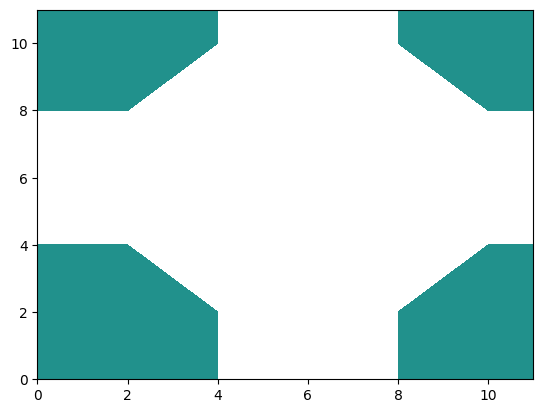

In [15]:
plt.contourf(corners())

In [16]:
def diag_mask(array):
    size = array.shape[0]
    return map2d(array, lambda _, i, j: (np.abs(i - j) > np.ceil(size/8.)))

def diag():
    size = 7
    z = np.zeros([size, size])
    a = np.where(diag_mask(z), np.random.rand(1), np.NAN)
    return(a)

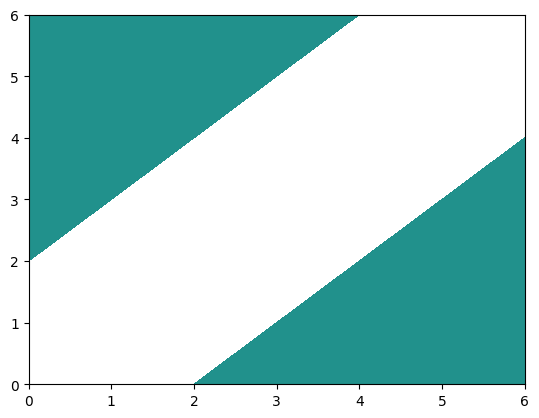

In [17]:
plt.contourf(diag())

In [80]:
def point_to_graph(mask, i, j, imax, jmax, weight=1.0):
    edges = []

    if not (j == jmax):
        if mask[i, j+1]:
            edges.append([(i,j), (i,j+1), weight])

    if not (i == imax):
        if mask[i+1,j]:
            edges.append([(i,j), (i+1,j), weight])

    return edges

In [18]:
def np_point_degree(array, i, j):
    return np.sum(np.isnan([array([i,j+1]),
                            array([i,j-1]),
                            array([i+1,j]),
                            array([i-1,j])]))

def np_array_to_graph(array):
    graph = nx.Graph()
    mask = np.isnan(array)

    imax = array.shape[0]-1
    jmax = array.shape[1]-1

    for i in range(0, imax+1):
        for j in range(0, jmax+1):
            if not mask[i,j]:
                graph.add_node((i,j))
                edges = point_to_graph(mask, i, j, imax, jmax)
                graph.add_weighted_edges_from(edges)
            
    return graph

def np_mask_to_graph(mask):
    array = np.zeros(mask.shape)
    for i in range(0, array.shape[0]):
        for j in range(0,array.shape[1]):
            if not mask[i, j]:
                array[i, j] = np.nan
    return np_array_to_graph(array)

def np_array_to_subgraphs(array):
    g = np_array_to_graph(array)
    return [g.subgraph(sub) for sub in nx.connected_components(g)]

def np_mask_to_subgraphs(mask):
    g = np_mask_to_graph(mask)
    return [g.subgraph(sub) for sub in nx.connected_components(g)]

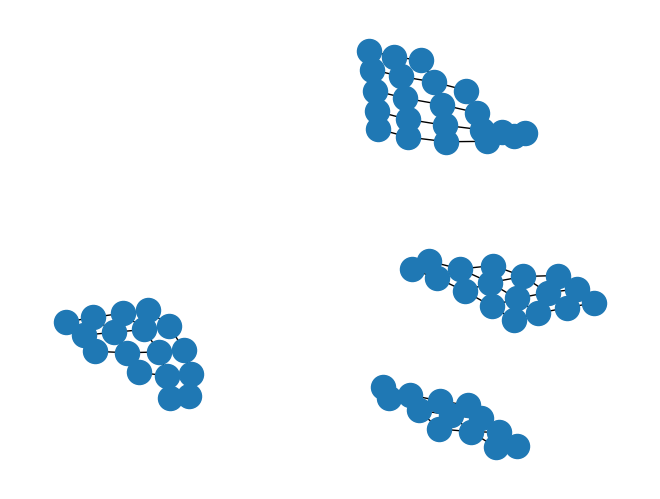

In [19]:
c = corners()
gc = np_array_to_graph(c)
nx.draw(gc)

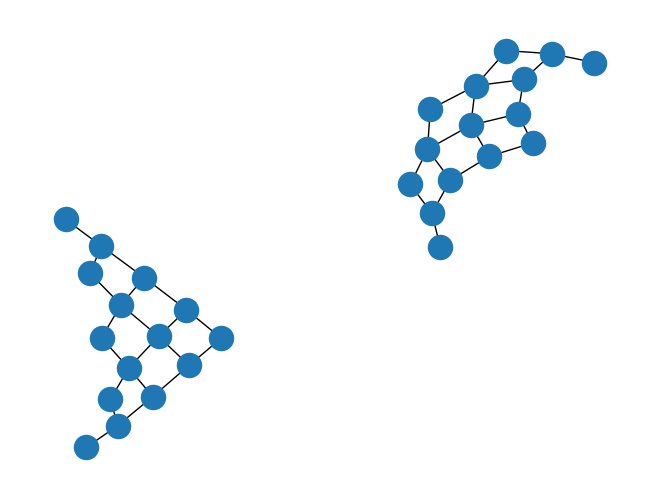

In [20]:
d = diag()
gd = np_array_to_graph(d)
nx.draw(gd)

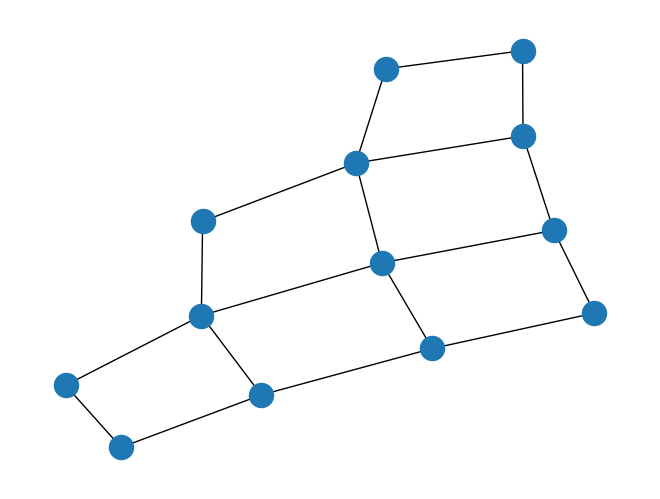

In [21]:
subgc = np_array_to_subgraphs(c)
subgd = np_array_to_subgraphs(d)
nx.draw(subgc[3])

In [ ]:

def xr_ds_to_graph(batch, sc, mask):
    mask = batch['mask'].to_numpy()
    
    imax = mask.shape[0]-1
    jmax = mask.shape[1]-1

    conv_f   = {x:batch[x].to_numpy() for x in sc.conv_var}
    features = {x:batch[x].to_numpy() for x in sc.input_var}
    targets  = {x:batch[x].to_numpy() for x in sc.target}
    conv_f_graph   = nx.Graph()
    features_graph = nx.Graph()
    targets_graph  = nx.Graph()
    
    for i in range(0, imax+1):
        for j in range(0, jmax+1):
            if mask[i, j]:
                conv_f_ij   = {x:conv_f  [x][i,j] for x in sc.conv_var}
                features_ij = {x:features[x][i,j] for x in sc.input_var}
                targets_ij  = {x:targets [x][i,j] for x in sc.target}
                conv_f_graph.add_node((i,j),   **conv_f_ij)
                features_graph.add_node((i,j), **features_ij)
                targets_graph.add_node((i,j),  **targets_ij)

                edges = point_to_graph(mask, i, j, imax, jmax)
                
                conv_f_graph.add_weighted_edges_from(edges,)
                features_graph.add_weighted_edges_from(edges,)
                targets_graph.add_weighted_edges_from(edges,)

    return conv_f_graph, features_graph, targets_graph
    
def xr_ds_to_subgraphs(batch, sc):
    c, f, t = xr_ds_to_graph(batch, sc)
    csub = [c.subgraph(sub) for sub in nx.connected_components(c)]
    fsub = [f.subgraph(sub) for sub in nx.connected_components(f)]
    tsub = [t.subgraph(sub) for sub in nx.connected_components(t)]
    return csub, fsub, tsub
    

In [61]:
# bgen = xb.BatchGenerator(
#     ds_training,
#     {'nlon':6, 'nlat':6},
#     {'nlon':2, 'nlat':2}
# )

In [62]:
# for batch in bgen:
#     a = batch
#     break
# a

In [27]:
# TEMP: formalize this

nlats = 5
nlons = 5
halo_size=1

In [28]:
latlen = len(ds_training['nlat'])
lonlen = len(ds_training['nlon'])
nlon_range = range(nlons,lonlen,nlons - 2*halo_size)
nlat_range = range(nlats,latlen,nlats - 2*halo_size)

batch = (
    ds_training
    .rolling({"nlat": nlats, "nlon": nlons})
    .construct({"nlat": "nlat_input", "nlon": "nlon_input"})[{'nlat':nlat_range, 'nlon':nlon_range}]
    .stack({"input_batch": ("nlat", "nlon")}, create_index=False)
    .rename_dims({'nlat_input':'nlat', 'nlon_input':'nlon'})
    .transpose('input_batch',...)
    # .chunk({'input_batch':32, 'nlat':nlats, 'nlon':nlons})
    .dropna('input_batch')
)

In [29]:
rnds = list(range(len(batch['input_batch'])))
np.random.shuffle(rnds)
batch = batch[{'input_batch':(rnds)}]

In [64]:
len(batch['input_batch'])

20930

In [81]:
# Need to convert arrays to subgraphs BEFORE the
# user-level batch generator, because we don't know
# how many subgraphs 'batch_to_subgraphs' is going
# to return 

def ggen_subgs(batch_set):
    for i in range(len(batch_set['input_batch'])):
        batch = batch_set[{'input_batch':i}]
        csub, fsub, tsub = xr_ds_to_subgraphs(batch, sc5)
        
        for j in range(len(fsub)):
            yield (from_networkx(csub[j]),
                   from_networkx(fsub[j]),
                   from_networkx(tsub[j]))
            


In [82]:
asdfasdf = ggen_subgs(batch)
next(asdfasdf)

(Data(edge_index=[2, 80], SSH=[25], SST=[25], weight=[80], num_nodes=25),
 Data(edge_index=[2, 80], X=[25], TAUX=[25], TAUY=[25], weight=[80], num_nodes=25),
 Data(edge_index=[2, 80], U=[25], V=[25], weight=[80], num_nodes=25))

In [ ]:
# This generator should be the user-level generator.
# At this point, it should basically be a generator wrapper
# that just converts subgraphs to torch_geometric Data arrays

def ggen(batch_set, batch_size, along='input_batch'):
    



In [60]:

a = ggen(batch, 32)
b = next(a)
b

1

In [41]:
# use with rolling
# def batch_generator(batch_set, batch_size):
#     n = 0
#     while n < len(batch_set['input_batch']) - batch_size:
#         yield batch_set.isel({'input_batch':range(n,(n+batch_size))})
#         n += batch_size
        
# # use with xbatcher
def batch_generator(bgen, batch_size):
    b = (batch for batch in bgen)
    n = 0
    while n < 400:
        batch_stack = [ next(b) for i in range(batch_size) ]
        yield xr.concat(batch_stack, 'sample')
        n += 1

In [42]:
# bgen = batch_generator(batch, 4096)
bgen = batch_generator(bgen, 32)

In [75]:
def bgen_to_graph(bgen, sc):
    for batch in bgen:
        csub, fsub, tsub = batch_to_subgraphs(batch, sc)
        for i in range(len(fsub)):
            yield csub[i], fsub[i], tsub[i]
            
# def count_bgen_subgraphs(bgen, sc)
#     ct = 0
#     for batch in bgen:
#         f, _ = batch_to_subgraphs(batch, sc)
#         ct += len(f)
#     return ct

In [76]:
for cg, fg, tg in bgen_to_graph(bgen, sc5):
    nx.draw(fg)
    break

In [73]:
for batch in bgen:
    batch_to_graph(batch, sc5)
    break

In [ ]:
def nodes_to_attributes(graphs, names):
    return [np.transpose(np.array([list(nx.get_node_attributes(g, name).values()) for name in names])) for g in graphs]

for batch in bgen:
    sc = sc5
    csub, fsub, tsub = batch_to_subgraphs(batch, sc)
    
    conv_f_graphs  = nodes_to_attributes(csub, sc.conv_var)
    feature_graphs = nodes_to_attributes(fsub, sc.input_var)
    target_graphs  = nodes_to_attributes(tsub, sc.target)
    
    break

In [75]:
a = from_networkx(batch[{'input_batch':range(100)}])
print(a)

AttributeError: 'Dataset' object has no attribute 'number_of_nodes'

In [ ]:
class MPD_in(MessagePassing):
    def __init__(self, in_channels, out_channels,message_channels):
        super().__init__(aggr='add')  # "Add" aggregation (Step 5).
        self.lin = torch.nn.Linear(in_channels, out_channels)
        self.lin_2 = torch.nn.Linear(in_channels, out_channels)        
        self.mlp = Seq(Linear(2 * in_channels + 2, message_channels),
                       ReLU(),
                       Linear(message_channels, in_channels))
        
    def forward(self, x, edge_index, edge_attr):
        # x has shape [N, in_channels]
        # edge_index has shape [2, E]
        
        # Step 4-5: Start propagating messages.
        
        out = self.propagate(edge_index, x=x, edge_attr=edge_attr)
        out += self.lin(x)
        return out

    def message(self, x_i, x_j, edge_attr):
        tmp = torch.cat([x_i,x_j,edge_attr],1)
        return self.lin_2(self.mlp(tmp)*(x_i-x_j))



In [ ]:
class MsgModelDiff(torch.nn.Module):

    def __init__(self,num_in = 1, num_out = 1,num_hidden = 30,num_message = 200):
        super().__init__()
        self.layer_diff = MPD_in(num_in,num_hidden,num_message)
        self.layer_h = MPD_in(num_hidden,num_hidden,num_message)
        self.layer_out = MPD_in(num_hidden,num_out,num_message)
        self.relu = torch.nn.ReLU()

        #self.layers = nn.ModuleList(layer)

    def forward(self,fts,adj,ew,batch):
        x = self.layer_diff(fts,adj,ew)
        x = self.relu(x)
        x = self.layer_h(x,adj,ew) 
        x = self.relu(x)  
        x = self.layer_h(x,adj,ew) 
        x = self.relu(x) 
        x = self.layer_h(x,adj,ew) 
        x = self.relu(x)    
        x = self.layer_out(x,adj,ew)
        return x

In [ ]:
class DxModel(torch.nn.Module):

    def __init__(self,num_in = 1, num_out = 1,num_hidden = 30):
        super().__init__()
        self.layer = torch_geometric.nn.GraphConv(num_in,num_hidden)
        self.layer_h = torch_geometric.nn.GraphConv(num_hidden,num_hidden)
        self.layer_out = torch_geometric.nn.GraphConv(num_hidden,num_out)
        self.relu = torch.nn.ReLU()

        #self.layers = nn.ModuleList(layer)

    def forward(self,fts,adj,ew,batch):
        x = self.layer(fts,adj,ew)
        x = self.relu(x)    
        x = self.layer_h(x,adj,ew) 
        x = self.relu(x)    
        x = self.layer_h(x,adj,ew) 
        x = self.relu(x)          
        x = self.layer_h(x,adj,ew) 
        x = self.relu(x)              
        x = self.layer_h(x,adj,ew) 
        x = self.relu(x)          
        x = self.layer_out(x,adj,ew)
        return x